In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as mpatches

In [3]:
# For higher resolution production graphs
mpl.rcParams['figure.dpi']= 150

In [4]:
# Function to quickly clean plot
def clean_plot():
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [5]:
import src.tools.chemidr.labeler as lbr
import src.tools.chemidr.id_map as id_map

In [6]:
phenol_explorer = pd.read_excel('data/composition-data.xlsx')

In [7]:
pe_garlic = phenol_explorer[phenol_explorer['food'].str.contains('Garlic')].copy()
pe_cocoa = phenol_explorer[phenol_explorer['food'].str.contains('Cocoa')].copy()

In [21]:
def id_loader(df, chem_key, load, file, fdb=True, pubchem=True):
    
    if load:
        df = pd.read_pickle(f'data/{file}')
    else:
        df = lbr.id_searcher(df, chem_key, fdb=fdb, pubchem=pubchem)
        df.to_pickle(f'misc_save/{file}')
    
    df.rename(columns={'pubchem_id' : 'chem_id_p', 'foodb_id' : 'chem_id_f'}, inplace=True)
    
    return df

# Saved ID's are loaded below
# pe_ids_g = id_loader(pe_garlic, 'compound', False, 'garlic_pe_ids.pkl')
# pe_ids_c = id_loader(pe_cocoa, 'compound', False, 'cocoa_pe_ids.pkl')

In [12]:
garlic_fm = pd.read_pickle('misc_save/garlic_quant_fm.pkl')
cocoa_fm = pd.read_pickle('misc_save/cocoa_quant_fm.pkl')

Number of Phenol Explorer compounds in garlic and cocoa: 5 , 35


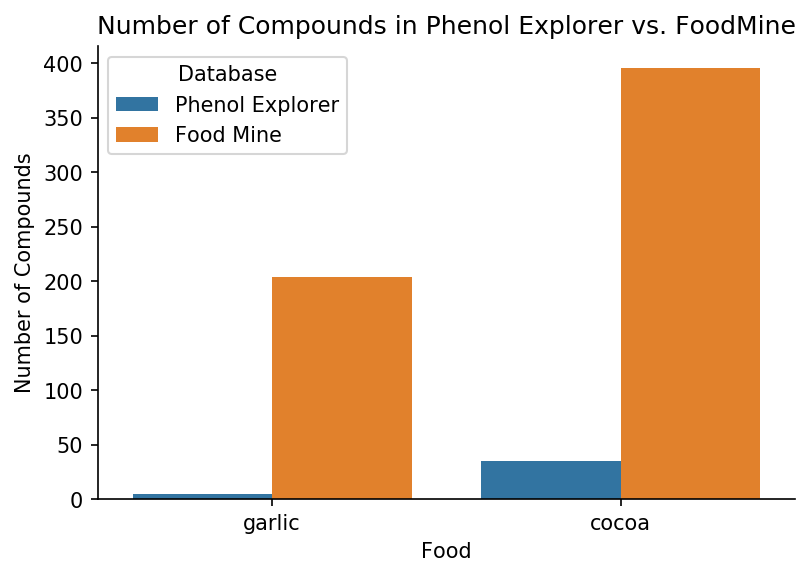

In [76]:
pe_distinct_ids_g = set(pe_ids_g['chem_id'].dropna().drop_duplicates().tolist())
pe_distinct_strings_g = set(pe_ids_g[pe_ids_g['chem_id'].isnull()]['compound'].drop_duplicates().tolist())
pe_distinct_ids_c = set(pe_ids_c['chem_id'].dropna().drop_duplicates().tolist())
pe_distinct_strings_c = set(pe_ids_c[pe_ids_c['chem_id'].isnull()]['compound'].drop_duplicates().tolist())

fm_distinct_ids_g = set(garlic_fm['chem_id'].dropna().drop_duplicates().tolist())
fm_distinct_strings_g = set(garlic_fm[garlic_fm['chem_id'].isnull()]['chemical'].drop_duplicates().tolist())
fm_distinct_ids_c = set(cocoa_fm['chem_id'].dropna().drop_duplicates().tolist())
fm_distinct_strings_c = set(cocoa_fm[cocoa_fm['chem_id'].isnull()]['chemical'].drop_duplicates().tolist())

num_measurements_pe_garlic = len(pe_distinct_ids_g) + len(pe_distinct_strings_g)
num_measurements_pe_cocoa = len(pe_distinct_ids_c) + len(pe_distinct_strings_c)

num_measurements_fm_garlic = len(fm_distinct_ids_g) + len(fm_distinct_strings_g)
num_measurements_fm_cocoa = len(fm_distinct_ids_c) + len(fm_distinct_strings_c)

print('Number of Phenol Explorer compounds in garlic and cocoa:', num_measurements_pe_garlic, ',', num_measurements_pe_cocoa)

viz = pd.DataFrame({
    'Number of Compounds' : [num_measurements_pe_garlic, num_measurements_pe_cocoa, num_measurements_fm_garlic, num_measurements_fm_cocoa],
    'Food' : ['garlic', 'cocoa', 'garlic', 'cocoa'],
    'Database' : ['Phenol Explorer', 'Phenol Explorer', 'Food Mine', 'Food Mine']
})


ax = sns.barplot(data=viz, x='Food', y='Number of Compounds', hue='Database')
ax.set_title('Number of Compounds in Phenol Explorer vs. FoodMine')
clean_plot()

In [56]:
num_overlap_garlic = len(pe_distinct_ids_g.intersection(fm_distinct_ids_g)) + len(pe_distinct_strings_g.intersection(fm_distinct_strings_g))
num_overlap_cocoa = len(pe_distinct_ids_c.intersection(fm_distinct_ids_c)) + len(pe_distinct_strings_c.intersection(fm_distinct_strings_c))

print('% of Phenol Explorer compounds in Garlic FoodMine:', (num_overlap_garlic/num_measurements_pe_garlic) * 100)
print('% of Phenol Explorer compounds in Cocoa FoodMine:', (num_overlap_cocoa/num_measurements_pe_cocoa) * 100)

% of Phenol Explorer compounds in Garlic: 0.0
% of Phenol Explorer compounds in Cocoa: 40.0


In [73]:
pe_papers_garlic = set([i.strip() for j in [str(p).split(';') for p in pe_garlic['pubmed_ids'].tolist()] for i in j])
pe_papers_cocoa = set([i.strip() for j in [str(p).split(';') for p in pe_cocoa['pubmed_ids'].tolist()] for i in j])

fm_papers_garlic = set([i for j in garlic_fm['papers'].tolist() for i in j])
fm_papers_cocoa = set([i for j in cocoa_fm['papers'].tolist() for i in j])

paper_overlap_g = pe_papers_garlic.intersection(fm_papers_garlic)
paper_overlap_c = pe_papers_cocoa.intersection(fm_papers_cocoa)

print("Number of papers in Phenol Explorere for garlic:", len(pe_papers_garlic))
print("Number of papers in Phenol Explorere for cocoa:" len(pe_papers_cocoa))
print('% of Phenol Explorer papers in Garlic FoodMine:', (len(paper_overlap_g)/len(pe_papers_garlic)) * 100)
print('% of Phenol Explorer papers in Cocoa FoodMine:', (len(paper_overlap_c)/len(pe_papers_cocoa)) * 100)

3
8
% of Phenol Explorer papers in Garlic FoodMine: 0.0
% of Phenol Explorer papers in Cocoa FoodMine: 0.0


In [79]:
num_overlap_cocoa

14

# Phenol-Explorer in CTD

In [15]:
def load_health():
    # Read in CTD data
    skip = list(range(26)) # First few lines are empty / not useful info
    hdata = pd.read_csv('data/CTD_chemicals_diseases.csv', skiprows=skip).reset_index()
    hdata.columns = ['ChemicalName', 'ChemicalID', 'CasRN', 'DiseaseName', 'DiseaseID', 'DirectEvidence', 'InferenceGeneSymbol', 'InferenceScore', 'OmimIDs', 'PubMedIDs']
    hdata = hdata.drop([0,1], axis = 0).reset_index(drop=True)

    # Pubchem ids of all chemicals in CTD
    health_pubchem_ids = pd.read_pickle('misc_save/health_chem_pubchem_ids.pickle').drop('pubchem_name', axis=1)

    hdata = hdata.merge(health_pubchem_ids, how='left', on='ChemicalName')

    # Count the number of 'Direct Evidence' listings per chemical with a pubchem id
    de_health = pd.DataFrame(
        hdata[hdata.pubchem_id.notnull() & hdata.DirectEvidence.notnull()][['pubchem_id', 'DirectEvidence', 'ChemicalName']]
        .groupby(['pubchem_id','DirectEvidence']).count()).reset_index()
    
    # The 'ChemicalName' now holds the count of 'Direct Evidence' listings
    return de_health[['pubchem_id', 'ChemicalName']].groupby('pubchem_id').sum().reset_index()

health = load_health()
health = health[health['ChemicalName'] > 0]

C:\software\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3248: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [20]:
health_pids = set(health['pubchem_id'].dropna().apply(int).tolist())

pe_garlic_pids = set(pe_ids_g['chem_id_p'].dropna().apply(int).tolist())
pe_cocoa_pids = set(pe_ids_c['chem_id_p'].dropna().apply(int).tolist())
pe_ids_both = set(list(pe_garlic_pids) + list(pe_cocoa_pids))

print('Number of Phenol-Explorer compounds with annotated health effects in CTD (garlic):', len(health_pids.intersection(pe_garlic_pids)))
print('Number of Phenol-Explorer compounds with annotated health effects in CTD (cocoa):', len(health_pids.intersection(pe_cocoa_pids)))
print('% of Phenol-Explorer compounds with annotated health effects in CTD (both):', len(health_pids.intersection(pe_ids_both)) / len(pe_ids_both))


Number of Phenol-Explorer compounds with annotated health effects in CTD (garlic): 1
Number of Phenol-Explorer compounds with annotated health effects in CTD (cocoa): 15
% of Phenol-Explorer compounds with annotated health effects in CTD (both): 0.46875
